In [17]:
import keras
import numpy as np
import pretty_midi
import librosa
import glob
import os
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
from train_util import NoteIsoSequence
from train_util import get_model
from train_util import program_map, one_hot_map

# synthesize without label and then add back for train?
# loud not at the end to force normalization?

In [2]:
midi_root_dir = "/home/faraaz/workspace/music-transcription/data/clean_midi/"
midi_files = glob.iglob(os.path.join(midi_root_dir, '**', '*.mid'))
midi_file = next(midi_files)
print(midi_file)

/home/faraaz/workspace/music-transcription/data/clean_midi/Redbone/Come and Get Your Love.mid


In [3]:
sf2_path="/usr/share/sounds/sf2/FluidR3_GM.sf2"
sample_rate = 44100
sample_duration = 44100
n_fft = 1024
pm = pretty_midi.PrettyMIDI(midi_file)
pm_samples = pm.fluidsynth(fs=sample_rate, sf2_path=sf2_path)

In [4]:
print(pm.instruments[0].notes[0])
note = pm.instruments[0].notes[0]
sample_start = int(note.start * sample_rate)
sample_end = sample_start + sample_duration

Note(start=51.199077, end=51.318123, pitch=81, velocity=105)


In [5]:
padded_samples = pm_samples[:]
if len(padded_samples > sample_start+sample_duration):
    print("hi")
    print(pm_samples.shape)
    padded_samples = padded_samples[sample_start:sample_start+sample_duration]
if len(padded_samples) < sample_duration:
    padded_samples = np.pad(padded_samples, (0, sample_duration-len(padded_samples)), 
                                'constant', constant_values=(0,0))

hi
(13841569,)


In [6]:
print(padded_samples.shape)
print(padded_samples[-1])
ipd.Audio(padded_samples, rate=sample_rate)

(44100,)
0.06190841647480174


(513, 173)
(-3.7645088e-05+0j)


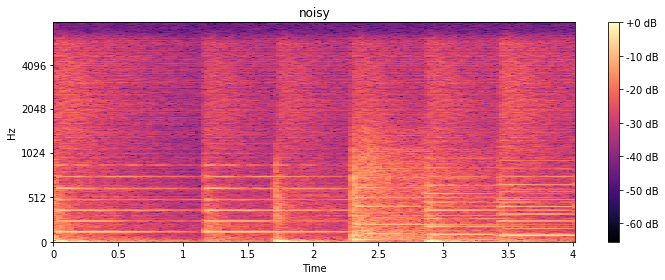

In [7]:
noisy_stft = librosa.core.stft(y=padded_samples, n_fft=n_fft)
print(noisy_stft.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(np.abs(noisy_stft), ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('noisy')
plt.tight_layout()
print(noisy_stft[-1][-1])

In [8]:
final_noisy = np.stack((noisy_stft.real, noisy_stft.imag), axis=2)
print(final_noisy.shape)

(513, 173, 2)


In [9]:
annotation = np.zeros((1, final_noisy.shape[1], final_noisy.shape[2]))
print(annotation.shape)
annotation[0,0,0] = note.pitch
annotation[0,0,1] = note.end - note.start
final_input = np.append(final_noisy, annotation, axis=0)
print(final_input.shape)

(1, 173, 2)
(514, 173, 2)


In [10]:
train_generator = NoteIsoSequence(midi_file, sample_duration=sample_duration, 
                                  fs=sample_rate, n_fft=n_fft, mode='train')
valid_generator = NoteIsoSequence(midi_file, sample_duration=sample_duration, 
                                  fs=sample_rate, n_fft=n_fft, mode='train', debug=True)

In [11]:
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 514, 173, 30)      570       
_________________________________________________________________
activation_1 (Activation)    (None, 514, 173, 30)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 514, 173, 30)      692       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 43, 30)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 43, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 43, 60)        16260     
_________________________________________________________________
activation_2 (Activation)    (None, 64, 43, 60)        0         
__________

In [12]:
model.fit_generator(generator=train_generator,
                    validation_data=train_generator,
                    use_multiprocessing=True,
                    workers=6, steps_per_epoch=1, epochs=1,
                    validation_steps=1)

Epoch 1/1
1/1 [==============================] - 4s 4s/step - loss: 3.3857 - val_loss: 15.5188


In [21]:
model = keras.models.load_model('draft-3.h')

In [22]:
num_instruments = len(pm.instruments)
for instr_index in range(num_instruments):
    instrument = pm.instruments[instr_index]
    print(instrument)
    num_notes = len(instrument.notes)
    test_size = min(num_notes, 100)
    note_indices = np.random.choice(range(num_notes), test_size, replace=False)
    instr_indices = [instr_index]*test_size

    test_generator = NoteIsoSequence(midi_file, sample_duration=sample_duration, 
                                     fs=sample_rate, n_fft=n_fft, instr_indices=instr_indices,
                                     note_indices=note_indices, mode='test')

    predicted = model.predict_generator(test_generator, steps=1)
    if instrument.is_drum:
        program = 0
    else:
        program = one_hot_map[program_map[instrument.program + 1]]
    print("one hot program: {}".format(program))
    prediction_list = ""
    for i in range(11):
        prediction_list += "{} ".format(np.count_nonzero(np.argmax(predicted, axis=1) == i))
    print(prediction_list)
    correct = np.count_nonzero(np.argmax(predicted, axis=1) == program)
    print("{} correct".format(correct))
    print("{}% correct".format(correct / len(predicted) * 100))

Instrument(program=0, is_drum=False, name="A.PIANO 1")
one hot program: 1
34 24 0 0 14 0 0 0 0 28 0 
24 correct
24.0% correct
Instrument(program=73, is_drum=False, name="MELODY")
one hot program: 9
26 17 0 0 2 0 0 0 0 55 0 
55 correct
55.00000000000001% correct
Instrument(program=26, is_drum=False, name="JAZZ GTR")
one hot program: 4
11 8 0 0 75 0 0 0 0 6 0 
75 correct
75.0% correct
Instrument(program=0, is_drum=True, name="DRUMS")
one hot program: 0
44 16 0 0 6 0 0 0 0 34 0 
44 correct
44.0% correct
